## Importing libraries

In [287]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests
import os.path
import re

## Data reading from web

***

### <span style="color:red">The code below takes quite long to be run and sometimes it hangs.</span>  

***

It is for illustration of initial data collection only. **For practice, the saved csv files should be imported.**

### Read tables sorted by UFO observation date

This returns a list of dataframes, the `[0]` element being a dataframe showing UFOs by date.  
The dataframes corresponding to each shape can then be retrieved from
`http://www.nuforc.org/webreports/ndxs{YYYYMM}.html`. The `{date}` in the url should be empty for `Unspecified` date.

In [ ]:
tables_by_date_list = pd.read_html('http://www.nuforc.org/webreports/ndxevent.html')

The code below saves each table as local html file for further import if necessary. This is done because reading of numerous files from the server is unstable and often fails. Saving the html files can be restarted if needed - only the missing files will be downloaded during subsequent runs. Overall, **the downloading takes about 25 minutes**.

In [ ]:
if not os.path.exists('by_date'):
        os.mkdir('by_date')

for date in tables_by_date_list[0].Reports:
    if date == 'UNSPECIFIED / APPROXIMATE':
        url = 'http://www.nuforc.org/webreports/ndxe.html'
        file = 'by_date/unspecified.html'
    else:
        url = f'http://www.nuforc.org/webreports/ndxe{date[-4:]}{date[:2]}.html'
        file = 'by_date/' + date.replace('/', '_') + '.html'
    
    if not os.path.isfile(file):
        r = requests.get(url, allow_redirects=True)
        open(file, 'wb').write(r.content)
        # optional text output to monitor the process
        #print(file)

The code below is for reading the tables from url directly to the dataframe. If often fails; when successful, **<ins>the reading takes about an hour</ins>**

In [ ]:
ufo_by_date = []

for date in tables_by_date_list[0].Reports:
    #print(f'Reading data for shape = {shape_name}...')
    if date == 'UNSPECIFIED / APPROXIMATE':
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxe.html')[0]
        temp_df['Date_label'] = date
        ufo_by_date.append(temp_df)
    else:
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxe{date[-4:]}{date[:2]}.html')[0]
        temp_df['Date_label'] = date
        ufo_by_date.append(temp_df)
    # optional text output to monitor the process
    #print(f'Reading data for date = {date} done!')

finish_reading_by_date = pd.Timestamp.now()    
    
ufo_raw_date = pd.concat(ufo_by_date)

Saving the dataframe for further use

In [ ]:
ufo_raw_date.reset_index(drop=True, inplace=True)

In [ ]:
ufo_raw_date.to_csv("ufo_raw_date.csv")

### Read tables sorted by UFO shape

This code returns a list of dataframes, the `[0]` element being a dataframe showing UFOs by type.  
The dataframes corresponding to each shape can then be retrieved from
`'http://www.nuforc.org/webreports/ndxs{shape_name}.html'`. The `{shape}` in the url should be empty for `Unspecified` shape.

In [275]:
tables_by_shape_list = pd.read_html('http://www.nuforc.org/webreports/ndxshape.html')

Subsequent code is similar to reading by date. The data reading to dataframe takes **<ins>about 20 minutes</ins>** and is not always stable. The data reading to file takes about **4 minutes**.

In [ ]:
if not os.path.exists('by_shape'):
        os.mkdir('by_shape')

for shape_name in tables_by_shape_list[0].Reports:
    if shape_name == 'Unspecified':
        url = 'http://www.nuforc.org/webreports/ndxs.html'
        file = 'by_shape/unspecified.html'
    else:
        url = f'http://www.nuforc.org/webreports/ndxs{shape_name}.html'
        file = 'by_shape/' + shape_name + '.html'
    
    if not os.path.isfile(file):
        r = requests.get(url, allow_redirects=True)
        open(file, 'wb').write(r.content)
        # optional text output to monitor the process
        print(file)

In [ ]:
ufo_by_shape = []

for shape_name in tables_by_shape_list[0].Reports:
    if shape_name == 'Unspecified':
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxs.html')[0]
    else:
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxs{shape_name}.html')[0]
    ufo_by_shape.append(temp_df)
    # optional text output to monitor the process
    #print(f'{shape_name} done!')

ufo_raw_shape = pd.concat(ufo_by_shape)

In [ ]:
ufo_raw_shape.to_csv("ufo_raw_shape.csv")

### Reading information about the states

Taking information from [wikipedia](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States)

In [458]:
tables_states_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States')

In [494]:
# general table about states
states_raw = tables_states_list[0]
states_raw.head()

Flag, name andpostal abbreviation[12]  \
  Flag, name andpostal abbreviation[12]   
0                               Alabama   
1                                Alaska   
2                               Arizona   
3                              Arkansas   
4                            California   

                                                Cities               \
  Flag, name andpostal abbreviation[12].1      Capital  Largest[16]   
0                                      AL   Montgomery   Birmingham   
1                                      AK       Juneau    Anchorage   
2                                      AZ      Phoenix      Phoenix   
3                                      AR  Little Rock  Little Rock   
4                                      CA   Sacramento  Los Angeles   

  Ratification oradmission[C] Population[14] Total area[15]           \
  Ratification oradmission[C] Population[14]            mi2      km2   
0                Dec 14, 1819        5024279          52420   135767   
1                 Jan 3, 1959         733391         665384  1723337   
2                Feb 14, 1912        7151502         113990   295234   
3                Jun 15, 1836        3011524          53179   137732   
4                 Sep 9, 1850       39538223         163695   423967   

  Land area[15]          Water area[15]         Numberof Reps.  
            mi2      km2            mi2     km2 Numberof Reps.  
0         50645   131171           1775    4597              7  
1        570641  1477953          94743  245384              1  
2        113594   294207            396    1026              9  
3         52035   134771           1143    2961              4  
4        155779   403466           7916   20501             53

In [523]:
%%capture

# Leaving area in km^2
states_final = states.iloc[:, [0, 1, 5, 7, 9]]
states_final.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

# Removing a note mark in the names
states_final.Name = states_final.Name.str.replace('[D]', '', regex=False)

states_final.Population = states_final.Population.astype('int64')

states_final

In [493]:
states_final.head()

,Name,Abbreviation,Population,Total_area,Land_area
0,Alabama,AL,5024279,135767,131171
1,Alaska,AK,733391,1723337,1477953
2,Arizona,AZ,7151502,295234,294207
3,Arkansas,AR,3011524,137732,134771
4,California,CA,39538223,423967,403466


In [524]:
states_final.dtypes

Name            object
Abbreviation    object
Population       int64
Total_area       int64
Land_area        int64
dtype: object

In [461]:
tables_states_list[1]

Name andpostal abbreviation[12]                                    \
  Name andpostal abbreviation[12] Name andpostal abbreviation[12].1   
0            District of Columbia                                DC   

        Established Population[14] Total area[15]      Land area[15]       \
        Established Population[14]            mi2  km2           mi2  km2   
0  Jul 16, 1790[17]         689545             68  176            61  158   

  Water area[15]     Numberof Reps.  
             mi2 km2 Numberof Reps.  
0              7  18           1[E]

In [497]:
# Information about District of Columbia

DC = tables_states_list[1].iloc[:, [0, 1, 3, 4, 6]]
DC.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']
DC

,Name,Abbreviation,Population,Total_area,Land_area
0,District of Columbia,DC,689545,68,61


In [462]:
tables_states_list[2]

Name andpostal abbreviation[12]                                    \
  Name andpostal abbreviation[12] Name andpostal abbreviation[12].1   
0                  American Samoa                                AS   
1                            Guam                                GU   
2        Northern Mariana Islands                                MP   
3                     Puerto Rico                                PR   
4             U.S. Virgin Islands                                VI   

                Capital Acquired[19]          Territorial status[20]  \
                Capital Acquired[19]          Territorial status[20]   
0         Pago Pago[21]         1900  Unincorporated, unorganized[G]   
1           Hagåtña[23]         1899       Unincorporated, organized   
2            Saipan[25]         1986    Unincorporated, organized[H]   
3          San Juan[26]         1899    Unincorporated, organized[H]   
4  Charlotte Amalie[28]         1917       Unincorporated, organized   

   Population[F] Total area[15]        Land area[15]       Water area[15]  \
   Population[F]            mi2    km2           mi2   km2            mi2   
0     57,400[22]            581   1505            76   198            505   
1    161,700[24]            571   1478           210   543            361   
2     52,300[24]           1976   5117           182   472           1793   
3  3,193,694[27]           5325  13791          3424  8868           1901   
4    103,700[29]            733   1898           134   348            599   

        Numberof Reps.  
    km2 Numberof Reps.  
0  1307           1[E]  
1   935           1[E]  
2  4644           1[E]  
3  4924           1[I]  
4  1550           1[E]

In [517]:
%%capture

territories = tables_states_list[2].iloc[:, [0, 1, 5, 7, 9]]
territories.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

# Removing coomments and useless commas
territories.Population = territories.Population\
        .astype('str')\
        .str.replace('\[..\]', '', regex=True)\
        .str.replace(',', '', regex=False)\
        .astype('int64')


In [518]:
territories

,Name,Abbreviation,Population,Total_area,Land_area
0,American Samoa,AS,57400,1505,198
1,Guam,GU,161700,1478,543
2,Northern Mariana Islands,MP,52300,5117,472
3,Puerto Rico,PR,3193694,13791,8868
4,U.S. Virgin Islands,VI,103700,1898,348


In [526]:
states = pd.merge(states_final, pd.merge(DC, territories, how='outer'), how='outer')

In [543]:
# States of Canada

canada = pd.read_html('https://en.wikipedia.org/wiki/Provinces_and_territories_of_Canada')[1]
canada = canada.iloc[:-1, [0, 1, 6, 7, 8]]
canada.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']
canada.Name = canada.Name.str.replace('[b]', '', regex=False)


canada

,Name,Abbreviation,Population,Total_area,Land_area
0,Ontario,ON,14789778,917741,158654
1,Quebec,QC,8585523,1356128,185928
2,Nova Scotia,NS,982326,53338,1946
3,New Brunswick,NB,783721,71450,1458
4,Manitoba,MB,1382904,553556,94241
5,British Columbia,BC,5174724,925186,19549
6,Prince Edward Island,PE,160536,5660,0
7,Saskatchewan,SK,1179906,591670,59366
8,Alberta,AB,4444277,642317,19531
9,Newfoundland and Labrador,NL,520286,373872,31340


In [544]:
states = pd.merge(states, canada, how='outer')

In [554]:
# Territories of Canada

canada_territories = pd.read_html('https://en.wikipedia.org/wiki/Provinces_and_territories_of_Canada')[2]
canada_territories = canada_territories.iloc[:-1, [0, 1, 6, 7, 8]]
canada_territories.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

canada_territories

,Name,Abbreviation,Population,Total_area,Land_area
0,Northwest Territories,NT,44991,1183085,163021
1,Yukon,YT,42596,474391,8052
2,Nunavut,NU,39536,1936113,157077


In [555]:
states = pd.merge(states, canada_territories, how='outer')

In [556]:
states.to_csv('states.csv')

## Data reading from local files

In [110]:
ufo_by_date = pd.read_csv('ufo_raw_date.csv', index_col=0)

In [111]:
ufo_by_shape = pd.read_csv('ufo_raw_shape.csv', index_col=0)

In [557]:
states = pd.read_csv('states.csv', index_col=0)

## Preliminary cleaning of the data

Number of rows of the dataframes obtained via import by shape and by date is the same. Additional column in `ufo_by_date` is the manually introduced `Date_label` column.

In [112]:
ufo_by_date.shape, ufo_by_shape.shape

((134841, 8), (134841, 7))

In [115]:
pd.merge(left=ufo_by_date, right=ufo_by_shape, how='outer', indicator=True)\
    .query('_merge != "both"').shape

(0, 9)

In [19]:
pd.merge(left=ufo_by_date, right=ufo_by_shape, how='outer', indicator=True)\
    .query('_merge == "both"').shape

(134847, 9)

Datasets collected by shape and by date are identical (result of the first merge is empty), but there are a few duplicates (esult of the second merge is longer than the initial dataframe).

We will further work with `ufo_raw_date` to keep "manual" date labels.

In [373]:
# making a copy to preserve source data
ufo = ufo_by_date.copy()

In [215]:
ufo

,Date / Time,City,State,Shape,Duration,Summary,Posted,Date_label
0,7/7/21 01:23,Moscow,ID,Light,30 min,Object moving across sky west to east that was...,7/31/21,07/2021
1,6/23/21 20:00,Medina,TN,Unknown,15 seconds,Unknown bright object disappears in a cloudles...,7/31/21,06/2021
2,6/22/21 01:00,Senji (India),NaN,Flash,15 seconds,I have that ufo video video as recorded 43 sec...,7/31/21,06/2021
3,6/21/21 19:30,York City (Brooklyn),NY,Circle,5 min6,A round white object (sphere) zoomed quickly i...,7/31/21,06/2021
4,6/21/21 14:45,San Jose,CA,Cylinder,10 Seconds,Capsule/Cylinder shaped object.,7/31/21,06/2021
...,...,...,...,...,...,...,...,...
134836,09?/?/1975,Oscoda,MI,Unknown,2-3 min,Funny flashing lights that hovered then just d...,6/6/00,UNSPECIFIED / APPROXIMATE
134837,NaN,Santa Maria,CA,Circle,19:00,Watching Sunday or Monday night football went ...,1/31/20,UNSPECIFIED / APPROXIMATE
134838,NaN,Rule,TX,Unknown,15 minutes,Unusual sounds and starlight distortion defini...,8/19/12,UNSPECIFIED / APPROXIMATE
134839,NaN,Graham,WA,Disk,2 minutes,Driving west on 224th looked right saw large c...,6/4/14,UNSPECIFIED / APPROXIMATE


In [210]:
ufo.dtypes

Date / Time    object
City           object
State          object
Shape          object
Duration       object
Summary        object
Posted         object
Date_label     object
dtype: object

We should consider converting `Date / Time` and `Posted` columns to datetime format.
On top of that, the column name with slash and spaces is not convenient.

In [374]:
ufo.rename(columns={'Date / Time': 'Observed'}, inplace=True)

In [229]:
round(sum(ufo.Date_label == 'UNSPECIFIED / APPROXIMATE') / ufo.shape[0] , 4)

0.0027

Parsing of poorly formatted dates/times is a complicated issue, but these are less than 0.3% of the observations. Hence, the solution is to remove such rows.

Then, we will remove too old observations (say, before 1900). This will resolve the issue of limited range of the `pd.datetime` type; moreover, these observations seem not reliable and too scarce to affect the conclusions.

Since year is coded by two last digits, we will extract it from the earlier introduced `Date_label` column. A new `Year` column will be created instead of just query because we will then use it to modify the `Observed` values

In [375]:
ufo = ufo.query('Date_label != "UNSPECIFIED / APPROXIMATE"')

# this is divided into two linea to suppress warning
years = ufo.Date_label.apply(lambda x: int(x[-4:]))
ufo['Year'] = years

ufo = ufo.query("Year >= 1900")

Without the following insertion of complete year, '68' would be converted to '2068'

In [376]:
times = []

for row in ufo.itertuples():
    date_complete_year = re.sub('/(.. )', '/' + str(row.Year) + ' ', row.Observed)
    times.append(date_complete_year)

ufo['Observed'] = pd.to_datetime(times, format="%m/%d/%Y %H:%M", errors='coerce')

Still, about 1.3% of the dates/times were not complete, even though not marked as 'UNSPECIFIED / APPROXIMATE"'  

An example of such entry is given below (day and time are missing)

In [234]:
round(ufo.Observed.isnull().sum() / ufo.shape[0], 3)

0.013

In [235]:
pd.DataFrame({
                'working': ufo.loc[134435, :],
                'as imported': ufo_by_date.loc[134435, :]
             })

,working,as imported
City,Meeting Creek (Canada),Meeting Creek (Canada)
Date / Time,NaN,12/24/14
Date_label,12/1914,12/1914
Duration,NaN,NaN
Observed,NaT,NaN
Posted,7/7/17,7/7/17
Shape,NaN,NaN
State,SK,SK
Summary,"I initially submitted this several years ago, ...","I initially submitted this several years ago, ..."
Year,1914,NaN


In the case of `Posted` date, conversion to `datetime` will be ambiguous anyway, but we will do it (maybe we will not use this column at all)

In [377]:
ufo.Posted = pd.to_datetime(ufo.Posted, format="%m/%d/%y", errors='coerce')

In [237]:
ufo.dtypes

Observed      datetime64[ns]
City                  object
State                 object
Shape                 object
Duration              object
Summary               object
Posted        datetime64[ns]
Date_label            object
Year                   int64
dtype: object

We don't need Date_label and Year columns any more

In [378]:
ufo.drop(columns=['Date_label', 'Year'], inplace=True)

Checking non-null data

In [241]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134452 entries, 0 to 134451
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Observed  132733 non-null  datetime64[ns]
 1   City      134135 non-null  object        
 2   State     125268 non-null  object        
 3   Shape     128871 non-null  object        
 4   Duration  128563 non-null  object        
 5   Summary   134382 non-null  object        
 6   Posted    134450 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(5)
memory usage: 12.2+ MB


number of totally incomplete observations (5 is for Observed, City, State, Shape, and Duration columns

In [242]:
ufo[ufo[['Observed', 'City', 'Shape', 'State', 'Duration']].isnull().sum(axis=1) == 5].shape[0]

49

filtering them out

In [379]:
ufo = ufo[ufo[['Observed', 'City', 'Shape', 'State', 'Duration']].isnull().sum(axis=1) < 5]

In [380]:
ufo.shape

(134403, 7)

About 99.7% of the data were retained at this step

In [247]:
round(ufo.shape[0] / ufo_by_date.shape[0], 4)

0.9968

Working with States column - we don't need states outside USA

In [558]:
states.tail(12)

,Name,Abbreviation,Population,Total_area,Land_area
57,Quebec,QC,8585523,1356128,185928
58,Nova Scotia,NS,982326,53338,1946
59,New Brunswick,NB,783721,71450,1458
60,Manitoba,MB,1382904,553556,94241
61,British Columbia,BC,5174724,925186,19549
62,Prince Edward Island,PE,160536,5660,0
63,Saskatchewan,SK,1179906,591670,59366
64,Alberta,AB,4444277,642317,19531
65,Newfoundland and Labrador,NL,520286,373872,31340
66,Northwest Territories,NT,44991,1183085,163021


In [559]:
ufo.query('State not in @states.Abbreviation.values').query('not State.isnull()').State.value_counts()

PQ    102
NF     43
SA     41
YK      6
Fl      5
QB      1
M0      1
Ca      1
Name: State, dtype: int64

* PQ is another assignment of Quebec (QC)
* NF stands for Newfoundland and Labrador (which is NL in the dataset)
* SA is for Sounth Australia
* YK seems to stand for Yukon (YT)
* Fl is misprinted FL (Florida)
* QB seems to be Quebec (QC) as well
* M0 is misprinted MO
* Ca is misprinted CA

In [560]:
new_state = {
                'State': {'PQ': 'QC',
                          'NF': 'NL',
                          'SA': np.nan,
                          'YK': 'YT',
                          'Fl': 'FL',
                          'QB': 'QC',
                          'M0': 'MO',
                          'Ca': 'CA'}
            }

ufo = ufo.replace(new_state)

In [563]:
ufo.query('State not in @states.Abbreviation.values').query('not State.isnull()')

,Observed,City,State,Shape,Duration,Summary,Posted


Now it is time to turn to duplicates

Four cases have complete duplicates

In [261]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])

,Observed,City,State,Shape,Duration,Summary,Posted
30165,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
30167,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
14406,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
14407,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
3200,2020-09-14 06:53:00,Aliquippa,PA,NaN,NaN,MADAR Node 68,2020-11-05
3201,2020-09-14 06:53:00,Aliquippa,PA,NaN,NaN,MADAR Node 68,2020-11-05
8538,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31
8557,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31
8581,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31
8601,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31


Four more observations differ in the Posted date

In [263]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])

,Observed,City,State,Shape,Duration,Summary,Posted
30165,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
30167,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
20683,2017-08-12 22:30:00,Mount Pleasant,OH,Flash,12 minutes,White flashing light moving irregularly throug...,2017-08-24
20682,2017-08-12 22:30:00,Mount Pleasant,OH,Flash,12 minutes,White flashing light moving irregularly throug...,2017-09-05
15061,2019-01-05 14:00:00,Detroit,MI,Flash,10 minutes,We witnessed 3 bright objects flying in a circ...,2019-01-11
15062,2019-01-05 14:00:00,Detroit,MI,Flash,10 minutes,We witnessed 3 bright objects flying in a circ...,2019-01-17
14406,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
14407,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
8533,2020-01-12 05:37:00,Mountlake Terrace,WA,NaN,NaN,MADAR Node 100,2020-01-31
8534,2020-01-12 05:37:00,Mountlake Terrace,WA,NaN,NaN,MADAR Node 100,2020-02-07


Quite many observations share place, time, and duration, but Summary is different.

Arbitrary inspection of several first cases show that there are minor textual differences in the Summary field. It seems dafe to consider them true duplicates.

No more investigation on duplicates on place, time and duration will be performed - let us consider that if at least duration is different, this can indicate multiple objects or multiple (=more reliable) observations of the same object.

In [267]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'], ascending=False)

,Observed,City,State,Shape,Duration,Summary,Posted
81,2021-06-09 13:30:00,Arlington,VA,Formation,1 Minute,Three Silent Objects with Colored Contrails in...,2021-07-31
82,2021-06-09 13:30:00,Arlington,VA,Formation,1 Minute,Three Objects with Colored Contrails in the Sk...,2021-07-31
124,2021-06-02 23:00:00,Albuquerque,NM,Cigar,5 minutes,I was in my grow room approximately 11:15 or s...,2021-07-31
123,2021-06-02 23:00:00,Albuquerque,NM,Cigar,5 minutes,I was in my grow room approximately 11:15 at n...,2021-07-31
298,2021-05-20 18:16:00,Manhattan,NY,Light,6 minutes,Small distant stationary object that slowly fl...,2021-07-31
...,...,...,...,...,...,...,...
17742,NaT,Austin,TX,NaN,NaN,((HOAX??)) On 4/7/18 there were 4 unidentifiab...,2018-04-13
124144,NaT,Atlanta,GA,NaN,NaN,"Comm./mil. (C-141) pilot reports ""jumble"" of v...",1999-11-02
102225,NaT,Atlanta,GA,NaN,NaN,Boom! Mystery solved Noises in sky just Lockhe...,2003-09-04
9434,NaT,NaN,NaN,Changing,NaN,There will be a sighting today. Two miles east...,2019-12-19


Hence, the decision is to remove duplicates basing on 'Observed', 'City', 'State', 'Shape', 'Duration' fields:

In [381]:
# this is not needed since we will drop duplicates later

#ufo.drop_duplicates(['Observed', 'City', 'State', 'Shape', 'Duration'], keep='first', inplace=True)

Upon this step, we have kept >99% of the observations.

Many of them (about 13.6%) have NaN in at least one of the columns, but let us consider these as partial potentially useful information.

In [271]:
round(ufo.shape[0] / ufo_by_date.shape[0], 4)

0.9925

In [272]:
round((ufo.shape[0] - ufo.dropna().shape[0]) / ufo.shape[0], 3)

0.136

Plan:
* **DONE** convert `Date / Time` to datetime
* **DONE** break datetime into date and time?
* **DONE** convert `posted` to date
* **DONE** remove duplicates
* aggregate common shapes
* remove duplicates again (probably not perform first deletion?)
* filter off old rare occasions (20%?)

In [382]:
ufo.Shape.str.lower().value_counts().sort_index()

changed           1
changing       3267
chevron        1541
cigar          3256
circle        14172
cone            537
crescent          2
cross           432
cylinder       2089
delta             8
diamond        1946
disk           7993
dome              1
egg            1167
fireball       9510
flare             1
flash          2364
formation      4490
hexagon           1
light         27463
other          9237
oval           5841
pyramid           1
rectangle      2294
round             2
sphere         8773
teardrop       1163
triangle      12121
triangular        1
unknown        9197
Name: Shape, dtype: int64

It seems reasonable to 
1) ignore case and 
2) consider (other synonims are possible but questionable):
* 'changed' = 'changing'
* 'cigar' = 'cylinder'
* 'delta' = 'triangular' = 'triangle'
* 'circle' = 'disk' = 'round' = 'sphere'
* 'flare' = 'light'
* 'other' = 'unknown'
* 'egg' = 'oval'
and
3) set NaN to 'unknown'

In [383]:
ufo.Shape = ufo.Shape.str.lower()

new_shape = {
                'Shape': {'changed': 'changing',
                          'cigar': 'cylinder',
                          'delta': 'triangle',
                          'triangular': 'triangle',
                          'disk': 'circle',
                          'round': 'circle',
                          'sphere': 'circle',
                          'flash': 'light',
                          'other': 'unknown',
                          'egg': 'oval',
                          np.nan: 'unknown'}
            }

ufo = ufo.replace(new_shape)

In [384]:
ufo.Shape.value_counts()

circle       30940
light        29827
unknown      23966
triangle     12130
fireball      9510
oval          7008
cylinder      5345
formation     4490
changing      3268
rectangle     2294
diamond       1946
chevron       1541
teardrop      1163
cone           537
cross          432
crescent         2
dome             1
flare            1
pyramid          1
hexagon          1
Name: Shape, dtype: int64

In [320]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'], ascending=False)

,Observed,City,State,Shape,Duration,Summary,Posted
8116,2020-02-06 19:45:00,Independence,MO,cylinder,30 seconds,Three MUFON investigators and other witnesses ...,2020-06-25
8115,2020-02-06 19:45:00,Independence,MO,cylinder,30 seconds,Huge UFO with brilliant lights flying low over...,2020-02-07
17509,2018-05-05 20:00:00,Clinton,MA,unknown,NaN,Object was jet black in color and had strange ...,2018-05-31
17510,2018-05-05 20:00:00,Clinton,MA,unknown,NaN,Object was jet black in color and had strange ...,2018-05-15
20990,2017-07-23 02:00:00,Pleasant Grove,UT,unknown,2 minutes,Saw what looked to be several points of light ...,2017-08-11
20989,2017-07-23 02:00:00,Pleasant Grove,UT,unknown,2 minutes,I was the one who reported this sighting that ...,2017-10-19
35700,2015-02-11 02:30:00,Port Orchard,WA,unknown,30 minutes,Low frequency pulsing followed by 30 minute po...,2015-02-12
35701,2015-02-11 02:30:00,Port Orchard,WA,unknown,30 minutes,"Feb. 11, 2015 Port Orchard incident",2015-02-20
43039,2014-04-12 21:21:00,Cedar Rapids,IA,circle,5 minutes,White/blue/green object and orange objects fly...,2014-04-18
43038,2014-04-12 21:21:00,Cedar Rapids,IA,circle,5 minutes,Two crafts spotted above Cedar Rapids.,2014-04-18


Since several additional duplicates have appeared at this step, we will again drop them

In [385]:
# not actually again - judt once here

ufo.drop_duplicates(['Observed', 'City', 'State', 'Shape', 'Duration'], keep='first', inplace=True)

In [386]:
# saving cleaned dataframe in case we distort it occasionally during analysis
ufo.to_csv("ufo_for_analysis.csv")

## Exploratory data analysis

Plan:
* **DONE** Fractions of observations by shape
* **DONE**Line Plot of observations by year
* **DONE**Line Plot of observations by year and shape
* Barplot of observations by state (raw and normalized by state population)
* Top counts by state + city

In [436]:
# start analysis from scratch
ufo = pd.read_csv('ufo_for_analysis.csv', index_col=0, parse_dates=['Observed', 'Posted'])

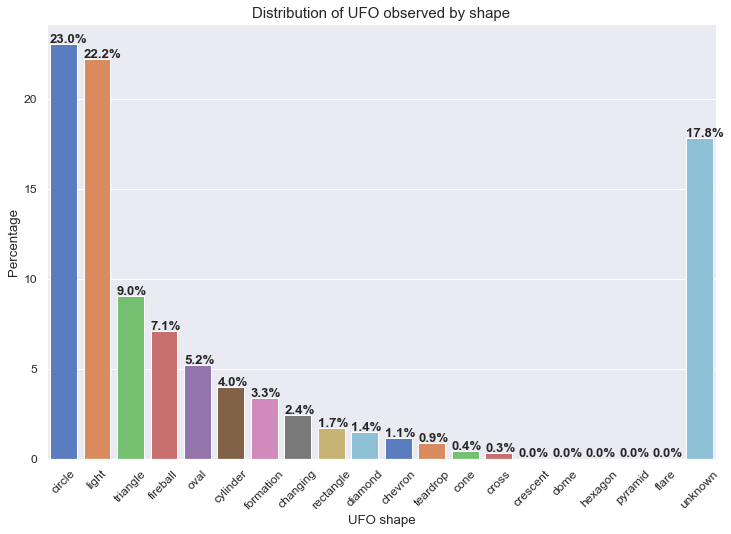

In [437]:
ufo_per_shape = ufo.groupby('Shape')\
        .agg(percentage =('Summary', lambda x: x.size / ufo.shape[0] * 100))\
        .sort_values(by='percentage', ascending=False)\
        .round(2)

idx = ufo_per_shape.index.tolist()
idx.remove('unknown')
ufo_per_shape = ufo_per_shape.reindex(idx + ['unknown'])

#Seaborn barplot
sns.set_style("whitegrid")

sns.set(font_scale=1.1)

bar,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=ufo_per_shape.index,
                 y='percentage',
                 data=ufo_per_shape,
                 ci=None,
                 palette="muted",
                 orient='v', )
ax.set_title("Distribution of UFO observed by shape", fontsize=15)
ax.set_xlabel ("UFO shape")
ax.set_ylabel ("Percentage")
ax.tick_params(axis='x', rotation=45)
# calculate the percentages and annotate the sns barplot
for rect in ax.patches:
    ax.text(rect.get_x(),rect.get_height() + 0.1,"%.1f%%"% rect.get_height(), weight='bold' );

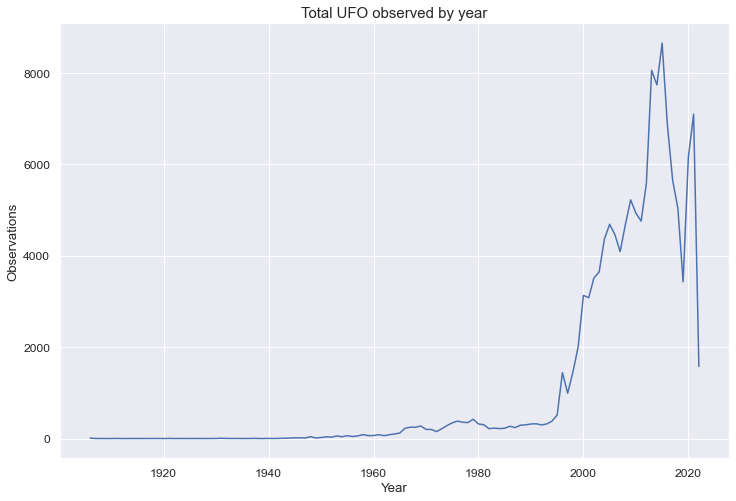

In [438]:
ufo_per_year = ufo.copy()
ufo_per_year.index = ufo.Observed
ufo_per_year = ufo_per_year.resample(rule='Y').Summary.count()

sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x=ufo_per_year.index,
                 y=ufo_per_year,
                 palette="muted")

ax.set_title("Total UFO observed by year", fontsize=15)
ax.set_xlabel ("Year")
ax.set_ylabel ("Observations");

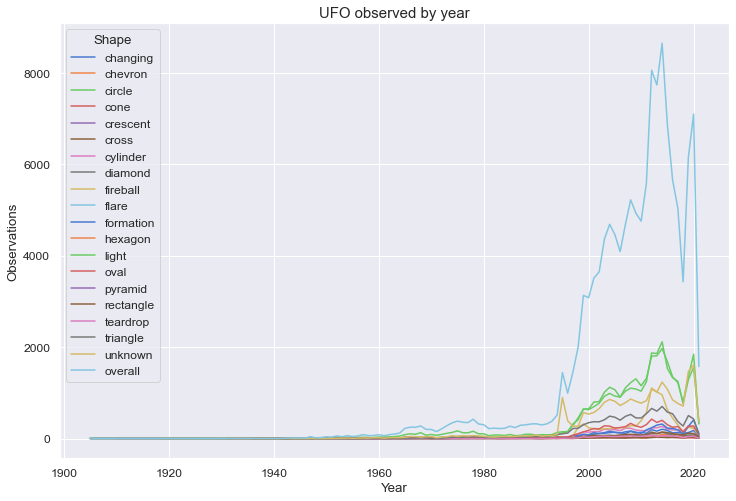

In [439]:
ufo_per_year_shape = ufo.assign(Year = ufo.Observed.dt.year)

ufo_per_year_shape = ufo_per_year_shape.groupby(['Year', 'Shape'], as_index=False)\
        .agg({'Summary': 'count'})\
        .pivot('Year', columns='Shape', values='Summary')

ufo_per_year_shape['overall'] = ufo_per_year_shape.sum(axis=1)

ufo_per_year_shape = ufo_per_year_shape.reset_index()\
    .melt(id_vars = 'Year', var_name='Shape',  value_name='Observations')



sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(data=ufo_per_year_shape,
                  x='Year',
                  y='Observations',
                  hue='Shape',
                 palette="muted")

ax.set_title("UFO observed by year", fontsize=15)
ax.set_xlabel ("Year")
ax.set_ylabel ("Observations");

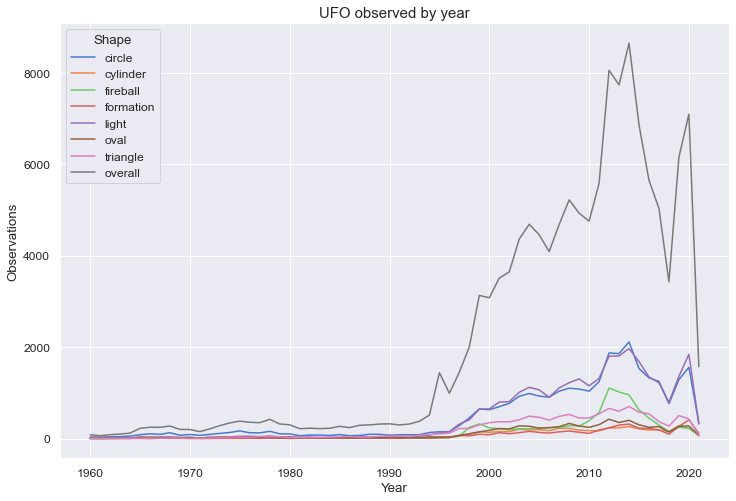

In [448]:
ufo_per_year_shape = ufo.assign(Year = ufo.Observed.dt.year)

ufo_per_year_shape = ufo_per_year_shape.groupby(['Year', 'Shape'], as_index=False)\
        .agg({'Summary': 'count'})\
        .pivot('Year', columns='Shape', values='Summary')

ufo_per_year_shape['overall'] = ufo_per_year_shape.sum(axis=1)

ufo_per_year_shape = ufo_per_year_shape.reset_index()\
    .melt(id_vars = 'Year', var_name='Shape',  value_name='Observations')

ufo_per_year_shape = ufo_per_year_shape.query("Shape in ['overall', 'circle', 'light', 'triangle', 'fireball', 'oval', 'cylinder', 'formation']")\
            .query("1960 <= Year <= 2021")


sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(data=ufo_per_year_shape,
                  x='Year',
                  y='Observations',
                  hue='Shape',
                 palette="muted")

ax.set_title("UFO observed by year", fontsize=15)
ax.set_xlabel ("Year")
ax.set_ylabel ("Observations");

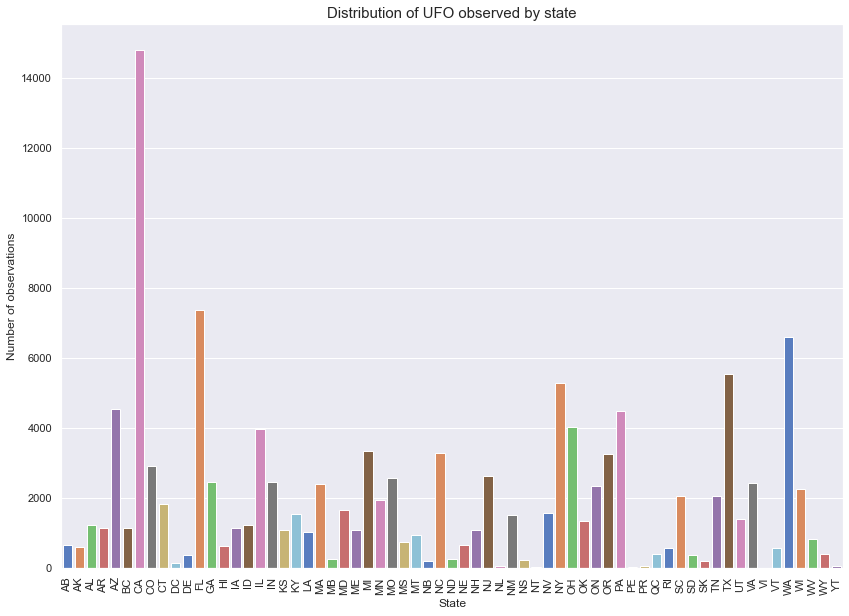

In [575]:
ufo_per_state = ufo.groupby('State', as_index=False)\
        .agg({'Summary': 'count'})\
        .rename(columns={'Summary': 'Observations'})\
        .sort_values(by='State', ascending=True)

#Seaborn barplot
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations")
ax.tick_params(axis='x', rotation=90)

Distribution by state is strongly uneven; let us normalize it to the state population and area

In [576]:
ufo_per_state = pd.merge(left=ufo_per_state, 
                         right=states, how='inner', 
                         left_on='State', 
                         right_on='Abbreviation')

In [577]:
ufo_per_state['Observations_per_population'] = ufo_per_state.Observations / ufo_per_state.Population
ufo_per_state['Observations_per_area'] = ufo_per_state.Observations / ufo_per_state.Total_area
ufo_per_state['Observations_per_land_area'] = ufo_per_state.Observations / ufo_per_state.Land_area

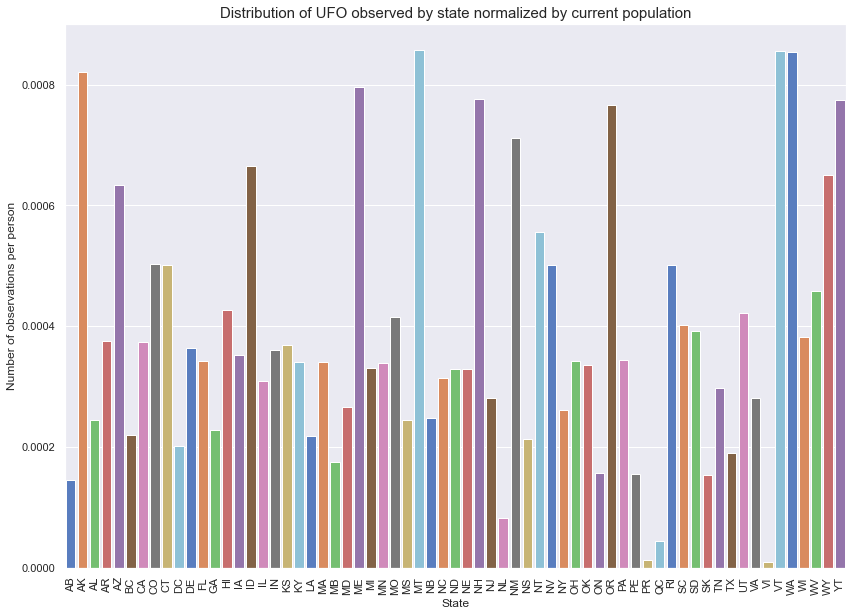

In [578]:
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations_per_population',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state normalized by current population", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations per person")
ax.tick_params(axis='x', rotation=90)

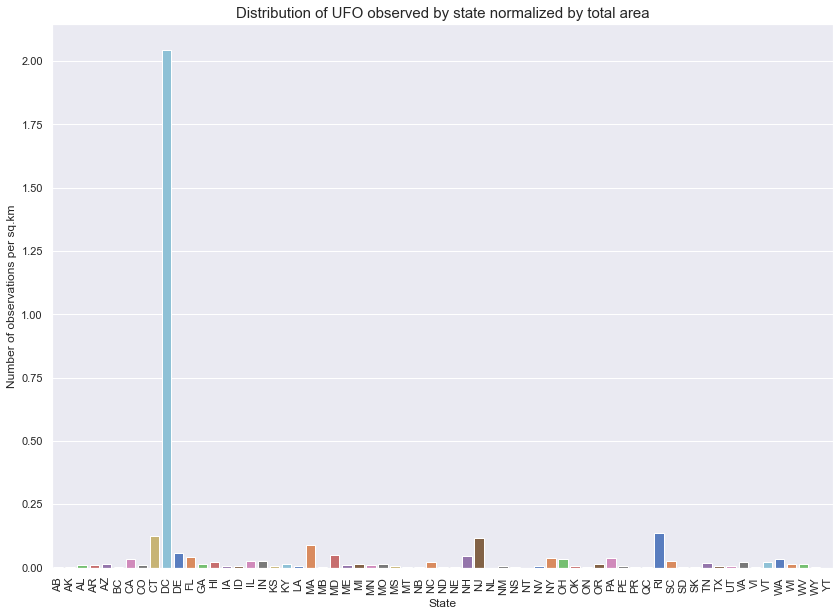

In [579]:
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations_per_area',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state normalized by total area", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations per sq.km")
ax.tick_params(axis='x', rotation=90)

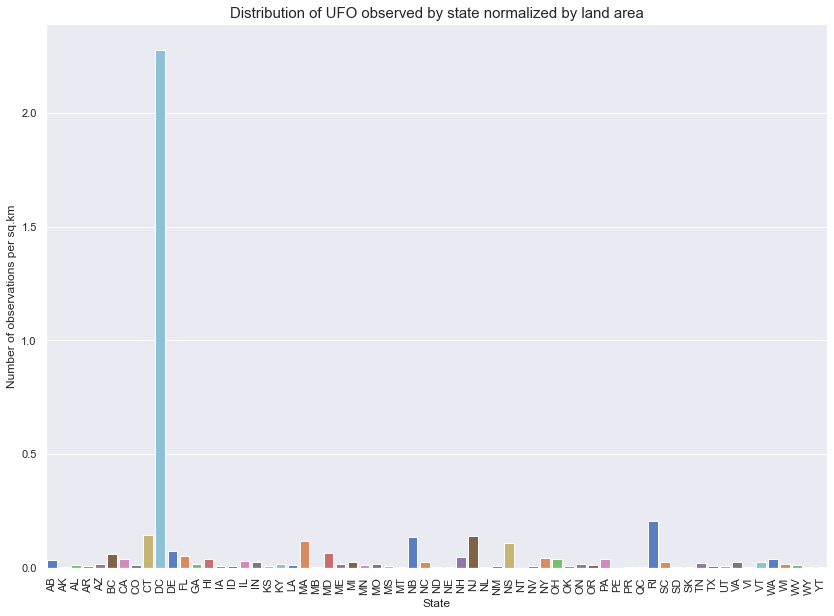

In [580]:
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations_per_land_area',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state normalized by land area", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations per sq.km")
ax.tick_params(axis='x', rotation=90)

In [587]:
def z_score(column):
    column.replace([np.inf, -np.inf], np.nan, inplace=True)
    return (column - column.mean())/column.std()


ufo_per_state['Observations_per_population_std'] = z_score(ufo_per_state['Observations_per_population'])
ufo_per_state['Observations_per_area_std'] = z_score(ufo_per_state['Observations_per_area'])
ufo_per_state['Observations_per_land_area_std'] = z_score(ufo_per_state['Observations_per_land_area'])

std_observations = ufo_per_state.loc[:, ['State', 'Observations_per_population_std', 'Observations_per_area_std', 'Observations_per_land_area_std']]

std_observations = pd.melt(frame=std_observations, 
        id_vars='State',
        value_vars=['Observations_per_population_std', 'Observations_per_area_std', 'Observations_per_land_area_std'],
        )

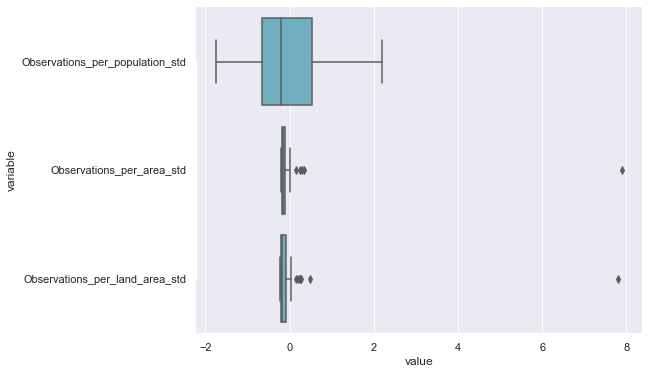

In [589]:
plt.figure(figsize=(8,6))
sns.boxplot(x="value", y="variable", data=std_observations, color="c")
sns.despine(trim=True)

In [571]:
ufo_per_state

,State,Observations,Name,Abbreviation,Population,Total_area,Land_area,Observations_per_population,Observations_per_area,Observations_per_land_area
0,CA,14806,California,CA,39538223,423967,403466,0.000374,0.034923,0.036697
1,FL,7365,Florida,FL,21538187,170312,138887,0.000342,0.043244,0.053029
2,WA,6583,Washington,WA,7705281,184661,172119,0.000854,0.035649,0.038247
3,TX,5523,Texas,TX,29145505,695662,676587,0.000189,0.007939,0.008163
4,NY,5271,New York,NY,20201249,141297,122057,0.000261,0.037304,0.043185
...,...,...,...,...,...,...,...,...,...,...
60,PR,38,Puerto Rico,PR,3193694,13791,8868,0.000012,0.002755,0.004285
61,YT,33,Yukon,YT,42596,474391,8052,0.000775,0.000070,0.004098
62,PE,25,Prince Edward Island,PE,160536,5660,0,0.000156,0.004417,inf
63,NT,25,Northwest Territories,NT,44991,1183085,163021,0.000556,0.000021,0.000153


In [435]:
ufo.dtypes

Unnamed: 0     int64
Observed      object
City          object
State         object
Shape         object
Duration      object
Summary       object
Posted        object
dtype: object